# Distributional models

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.lines import Line2D

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # ArviZ

az.style.use("arviz-doc")

For most regression models, a function of the mean (aka the location parameter) of the response distribution is defined as a linear function of certain predictors, while the remaining parameters are considered auxiliary. For instance, if the response is a Gaussian, we model $\mu$ as a combination of predictors and $\sigma$ is estimated from the data, but assumed to be constant for all observations.

Instead, with distributional models we can specify predictor terms for all parameters of the response distribution. This can be useful, for example, to model heteroskedasticity, i.e. unequal variance. In this notebook we are going to do exactly that. 

To better understand distributional models, let's begin fitting a non-distributional models. We are going to model the following syntetic dataset. And we are going to use a Gamma response with a `log` link function.

In [3]:
rng = np.random.default_rng(121195)
N = 200
a, b = 0.5, 1.1
x = rng.uniform(-1.5, 1.5, N)
shape = np.exp(0.3 + x * 0.5 + rng.normal(scale=0.1, size=N))
y = rng.gamma(shape, np.exp(a + b * x) / shape, N)
data = pd.DataFrame({"x": x, "y": y})
new_data = pd.DataFrame({"x": np.linspace(-1.5, 1.5, num=50)})

## Constant alpha

In [4]:
formula = bmb.Formula("y ~ x")
model_constant = bmb.Model(formula, data, family="gamma", link="log")
model_constant

       Formula: y ~ x
        Family: gamma
          Link: mu = log
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5037)
            x ~ Normal(mu: 0.0, sigma: 2.8025)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)

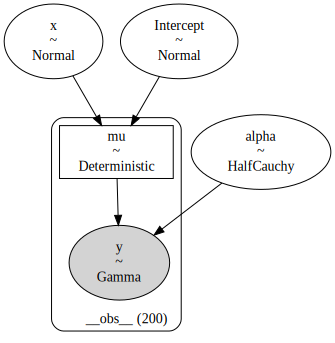

In [5]:
model_constant.build()
model_constant.graph()

Take a moment to inspect the textual and graphical representations of the model, to ensure you understand how the parameters are related.

In [6]:
idata_constant = model_constant.fit(random_seed=121195, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, Intercept, x]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Once the model is fitted let's visually inspect the result in terms of the mean (the line in the following figure) and the individual predictions (the band).

In [7]:
model_constant.predict(idata_constant, kind="response_params", data=new_data)
model_constant.predict(idata_constant, kind="response", data=new_data)

qts_constant = (
    az.extract(idata_constant.posterior_predictive, var_names="y")
    .quantile([0.025, 0.975], "sample")
    .to_numpy()
)
mean_constant = (
    az.extract(idata_constant.posterior_predictive, var_names="y")
    .mean("sample")
    .to_numpy()
)

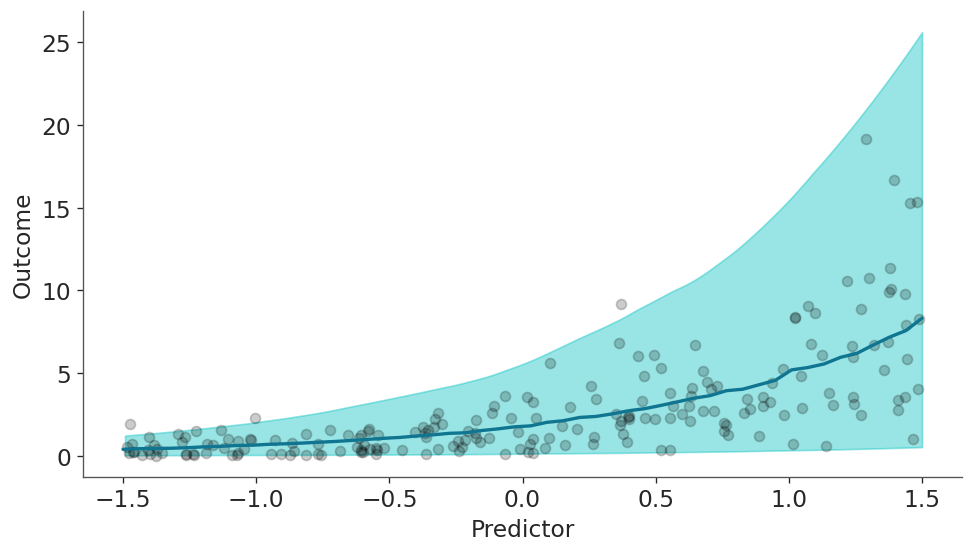

In [8]:
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=120)

az.plot_hdi(new_data["x"], qts_constant, ax=ax, fill_kwargs={"alpha": 0.4})
ax.plot(new_data["x"], mean_constant, color="C0", lw=2)
ax.scatter(data["x"], data["y"], color="k", alpha=0.2)
ax.set(xlabel="Predictor", ylabel="Outcome");

The model correctly model that the outcome increases with the values of the predictor. So far so good, let's dive into the heart of the matter.

## Varying alpha

Now we are going to build the same model as before with the only, but crucial difference, that we are also going to make alpha depend on the predictor. The syntax is very simple besides the usual "y ~ x", we now add "alpha ~ x". Neat! 

In [9]:
formula_varying = bmb.Formula("y ~ x", "alpha ~ x")
model_varying = bmb.Model(formula_varying, data, family="gamma", link={"mu": "log", "alpha": "log"})
model_varying

       Formula: y ~ x
                alpha ~ x
        Family: gamma
          Link: mu = log
                alpha = log
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5037)
            x ~ Normal(mu: 0.0, sigma: 2.8025)
    target = alpha
        Common-level effects
            alpha_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            alpha_x ~ Normal(mu: 0.0, sigma: 1.0)

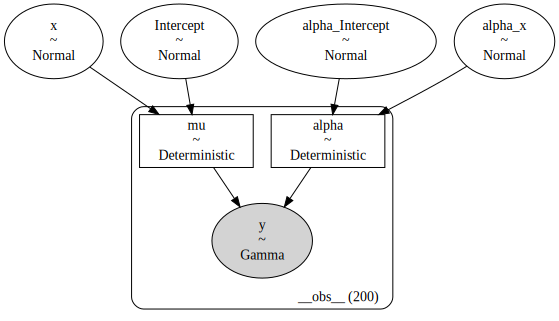

In [10]:
model_varying.build()
model_varying.graph()

Take another moment to inspect the textual and visual representations of `model_varying` and also go back and compare those from `model_constant`.

In [11]:
idata_varying = model_varying.fit(
    random_seed=121195, 
    idata_kwargs={"log_likelihood": True},
    include_response_params=True,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, x, alpha_Intercept, alpha_x]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Now, with both models being fitted, let's see how the alpha parameter differs between both models. In the next figure you can see a blueish KDE for the alpha parameter estimated with `model_constant` and 200 black KDEs for the alpha parameter estimated from the `model_varying`. You can count it if you want :-), but we know they should be 200 because we should have one for each one of the 200 observations.

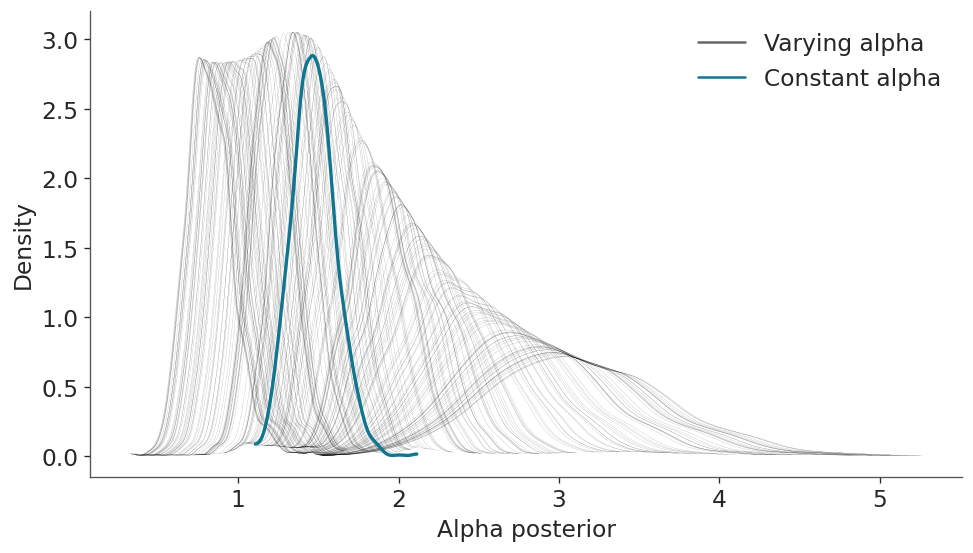

In [12]:
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=120)

for idx in idata_varying.posterior.coords.get("__obs__"):
    values = idata_varying.posterior["alpha"].sel(__obs__=idx).to_numpy().flatten()
    grid, pdf = az.kde(values)
    ax.plot(grid, pdf, lw=0.05, color="k")

values = idata_constant.posterior["alpha"].to_numpy().flatten()
grid, pdf = az.kde(values)
ax.plot(grid, pdf, lw=2, color="C0");

# Create legend
handles = [
    Line2D([0], [0], label="Varying alpha", lw=1.5, color="k", alpha=0.6),
    Line2D([0], [0], label="Constant alpha", lw=1.5, color="C0")
]

legend = ax.legend(handles=handles, loc="upper right", fontsize=14)

ax.set(xlabel="Alpha posterior", ylabel="Density");

This is nice statistical art and a good insight into what the model is actully doing. But at this point you may be wondering how results looks like and more important how different they are from `model_constant`. Let's plot the mean and predictions as we did before, but for both models.

In [13]:
model_varying.predict(idata_varying, kind="response_params", data=new_data)
model_varying.predict(idata_varying, kind="response", data=new_data)

qts_varying = (
    az.extract(idata_varying.posterior_predictive, var_names="y")
    .quantile([0.025, 0.975], "sample")
    .to_numpy()
)
mean_varying = (
    az.extract(idata_varying.posterior_predictive, var_names="y")
    .mean("sample")
    .to_numpy()
)

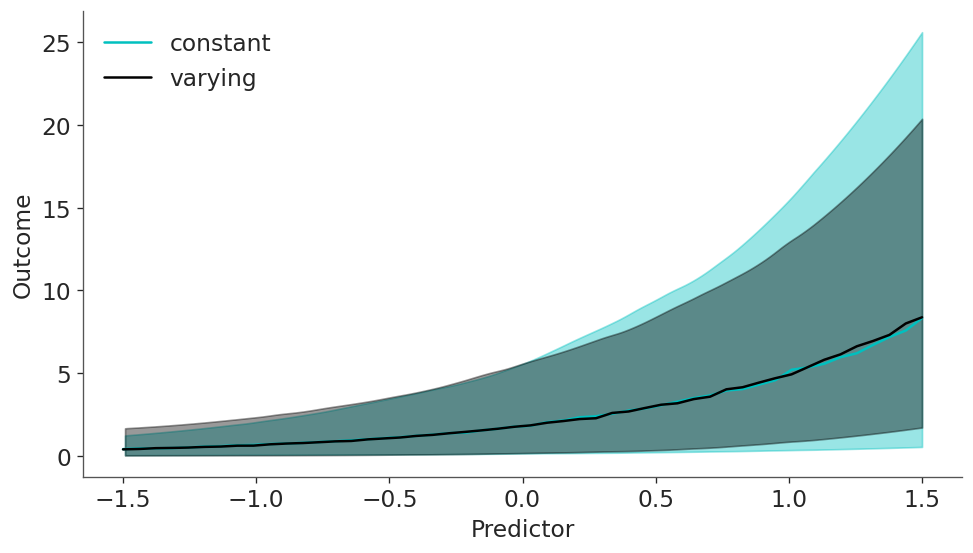

In [14]:
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=120)

az.plot_hdi(new_data["x"], qts_constant, ax=ax, fill_kwargs={"alpha": 0.4})
ax.plot(new_data["x"], mean_constant, color="C1", label="constant")

az.plot_hdi(new_data["x"], qts_varying, ax=ax, fill_kwargs={"alpha": 0.4, "color":"k"})
ax.plot(new_data["x"], mean_varying, color="k", label="varying")
ax.set(xlabel="Predictor", ylabel="Outcome");
plt.legend();

We can see that mean is virtually the same for both model but the predictions are not, in particular for larger values of the predictiors. 

We can also check that the models actually looks different under the LOO metric, with a slight preference for the varying model.

In [15]:
az.compare({"constant": idata_constant, "varying": idata_varying})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
varying,0,-309.143281,3.785955,0.000000,0.939557,16.468110,0.000000,False,log
constant,1,-318.913529,2.958352,9.770248,0.060443,15.832034,4.560753,False,log


## Distributional models with splines

Time to step up our game. In this example we are going to use the bikes [data set](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) from the University of California Irvine’s Machine Learning Repository, and we are going to estimate the number of rental bikes rented per hour over a 24 hour period. 

As the number of bikes is a count variable we are going to use a `negativebinomial` family, and we are going to use two splines: one for the mean, and one for alpha.

In [16]:
data = bmb.load_data("bikes")
# Remove data, you may later try to refit the model to the whole data
data = data[::50]
data = data.reset_index(drop=True)

In [17]:
formula = bmb.Formula(
    "count ~ 0 + bs(hour, 8, intercept=True)",
    "alpha ~ 0 + bs(hour, 8, intercept=True)"
)
model_bikes = bmb.Model(formula, data, family="negativebinomial")
model_bikes

       Formula: count ~ 0 + bs(hour, 8, intercept=True)
                alpha ~ 0 + bs(hour, 8, intercept=True)
        Family: negativebinomial
          Link: mu = log
                alpha = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            bs(hour, 8, intercept=True) ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0.], sigma: [11.3704 13.9185
                11.9926 10.6887 10.6819 12.1271 13.623  11.366 ])

    target = alpha
        Common-level effects
            alpha_bs(hour, 8, intercept=True) ~ Normal(mu: 0.0, sigma: 1.0)

In [18]:
idata_bikes = model_bikes.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bs(hour, 8, intercept=True), alpha_bs(hour, 8, intercept=True)]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [19]:
hour = np.linspace(0, 23, num=200)
new_data = pd.DataFrame({"hour": hour})
model_bikes.predict(idata_bikes, data=new_data, kind="response")

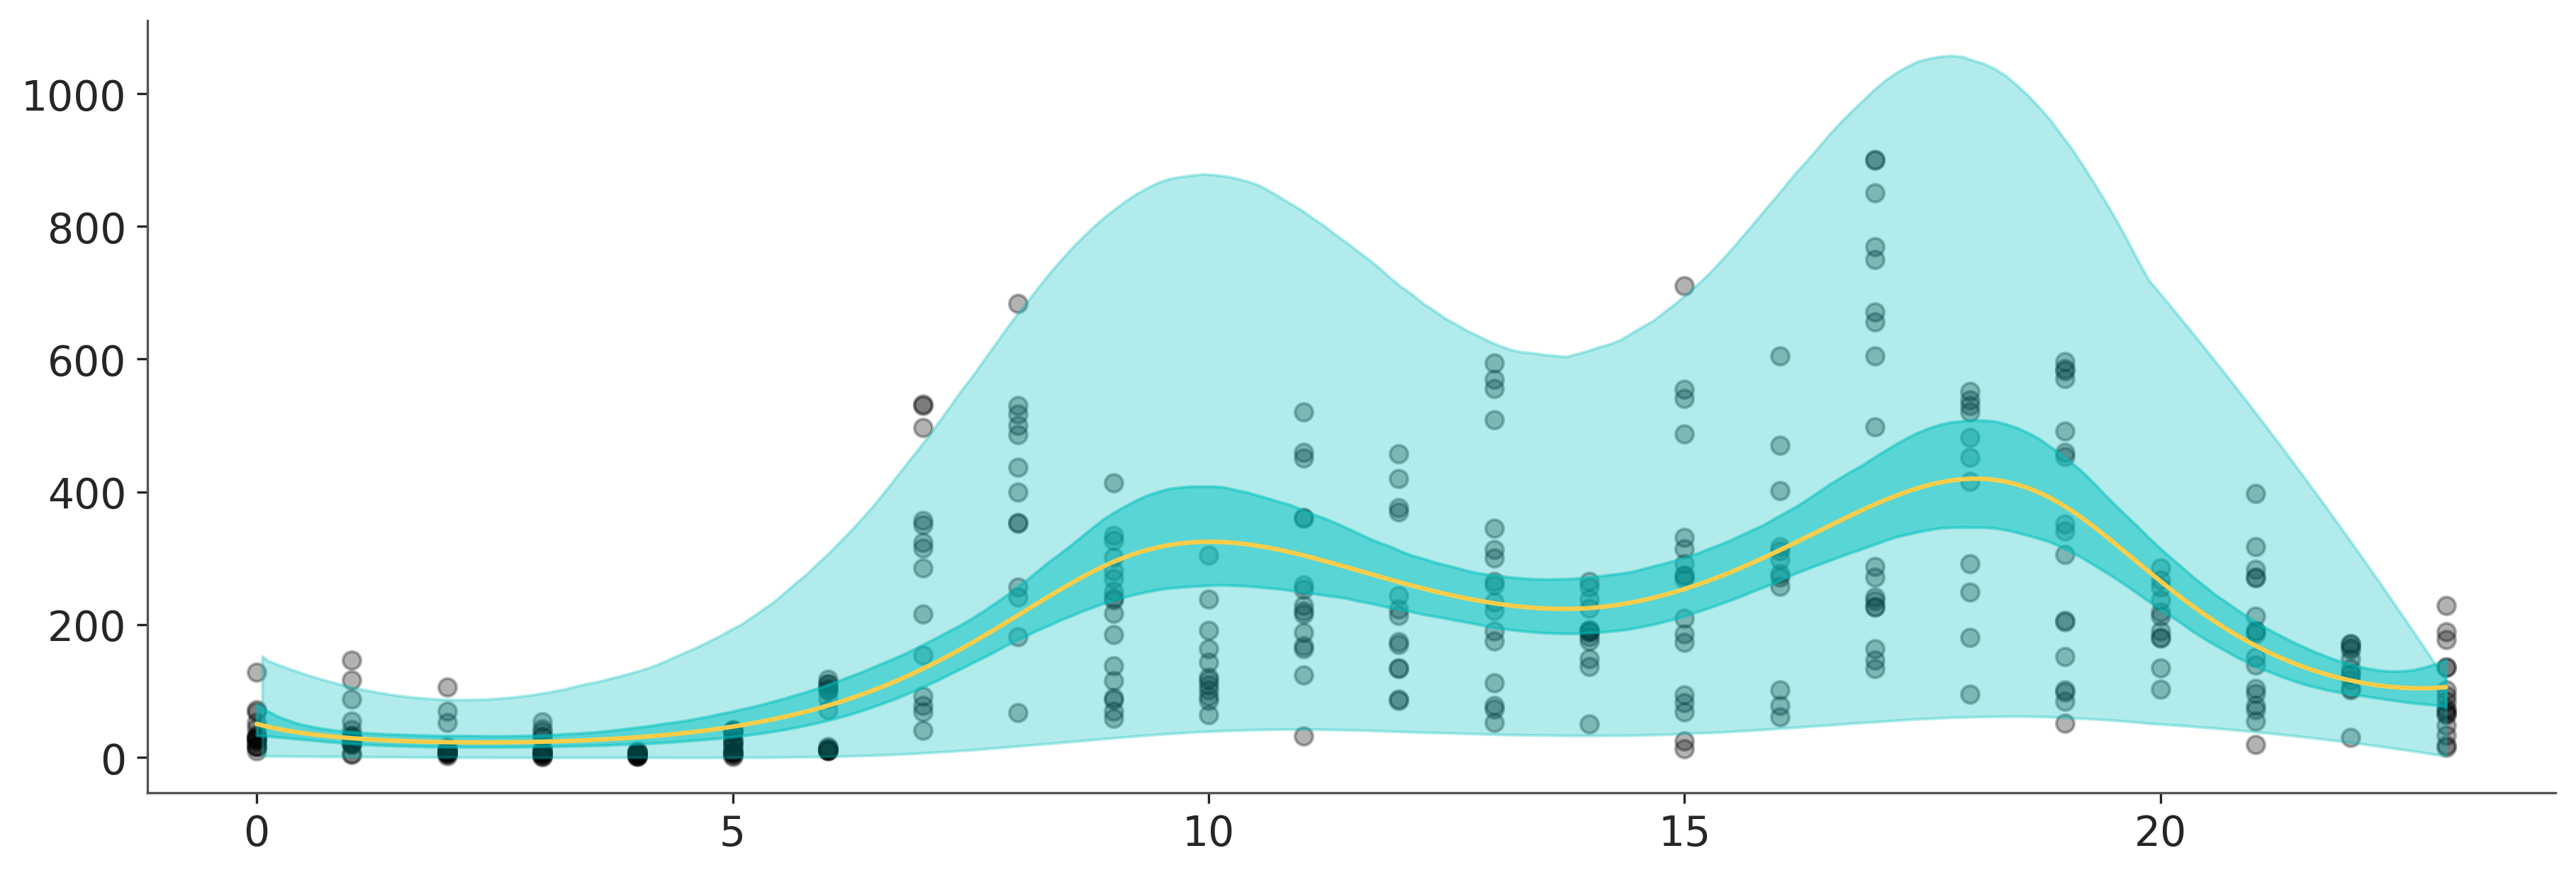

In [20]:
q = [0.025, 0.975]
dims = ("chain", "draw")

mean = idata_bikes.posterior["mu"].mean(dims).to_numpy()
mean_interval = idata_bikes.posterior["mu"].quantile(q, dims).to_numpy()
y_interval = idata_bikes.posterior_predictive["count"].quantile(q, dims).to_numpy()

fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(data["hour"], data["count"], alpha=0.3, color="k")
ax.plot(hour, mean, color="C3")
ax.fill_between(hour, mean_interval[0],mean_interval[1], alpha=0.5, color="C1");
az.plot_hdi(hour, y_interval, fill_kwargs={"color": "C1", "alpha": 0.3}, ax=ax);

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jul 04 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.24.0

numpy     : 1.26.4
arviz     : 0.18.0
matplotlib: 3.8.4
pandas    : 2.2.2
bambi     : 0.13.1.dev45+ge8510ea5.d20240704

Watermark: 2.4.3

